In [1]:
##############
### Import ###
##############

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

from scipy.optimize import curve_fit

#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import numpy as np
import astropy
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

In [2]:
hydrogen_wgt = 1.008 #IUPAC
atomic_wgts = np.array([15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
asplund = np.array([8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
a = sum(10**(asplund-12.00)*(atomic_wgts/hydrogen_wgt)*(1/0.0181)) # a = 0.78963627131196057
b = 1-a # b = 0.21036372868803943
print(a)
print(b)
print('Original Salaris a: ',0.638)
print('Original Salaris b: ',0.362)

0.5605413030674107
0.4394586969325893
Original Salaris a:  0.638
Original Salaris b:  0.362


In [3]:
def salariscorrectedfeh(abund):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.

    # hydrogen_wgt = 1.008 #IUPAC
    # atomic_wgts = np.array([15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
    # asplund = np.array([8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
    # ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
    # a = sum(10**(asplund-12.00)*(atomic_wgts/hydrowh_wgt)*(1/0.0181)) # a = 0.78963627131196057
    # b = 1-a # b = 0.21036372868803943

    Inputs:
    ------
        feh: metallcity of a star
        _alpha: array of abundances np.array([O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])

    Output:
    ------
        salfeh: Salaris corrected metallicity
    '''

    # Set things up
    nsamples = 1000
    asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
    feh = abund[0,0]
    feh_err = abund[0,1]
    _alpha = abund[1:,0]
    _alpha_err = abund[1:,1]

    salfehdist = 999999.0*np.ones(nsamples)

    for i in range(nsamples):

        # Assign solar value to stars if abundance is bad
        for j in range(len(_alpha)):
            if _alpha[j] < -100. or _alpha[j] > 10. or np.isfinite(_alpha[j])==False:
                _alpha[j] = 0.0
            if _alpha_err[j] < -100. or _alpha_err[j] > 10. or np.isfinite(_alpha_err[j])==False:
                _alpha_err[j] = 0.0

        if np.isfinite(feh) == False:
            feh = 0.0
            feh_err = 0.0

        # Create distribution for the different abundances
        feh_new = np.random.normal(feh,feh_err)
        _alpha_new = 999999.0*np.ones(len(_alpha))
        for k in range(len(_alpha)):
            _alpha_new[k] = np.random.normal(_alpha[k],_alpha_err[k])

        # Calculate enhancement factor and corrected metallicity
        fac_acn = sum(10**(asplund+_alpha_new))/sum(10**asplund)
        salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)

        salfehdist[i] = salfeh

    # Calculate the value and error from the distribution
    calc_salfeh = np.nanmedian(salfehdist)
    calc_salfeh_err = mad(salfehdist)

    return calc_salfeh, calc_salfeh_err

In [4]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_av = ccm_alav(leff['K'],3.1)

In [5]:
# plt.figure(figsize=[10,10])
# plt.plot(np.arange(1/3.3,1/0.3,(1/3.3-1/0.3)/1000))#,c='k')

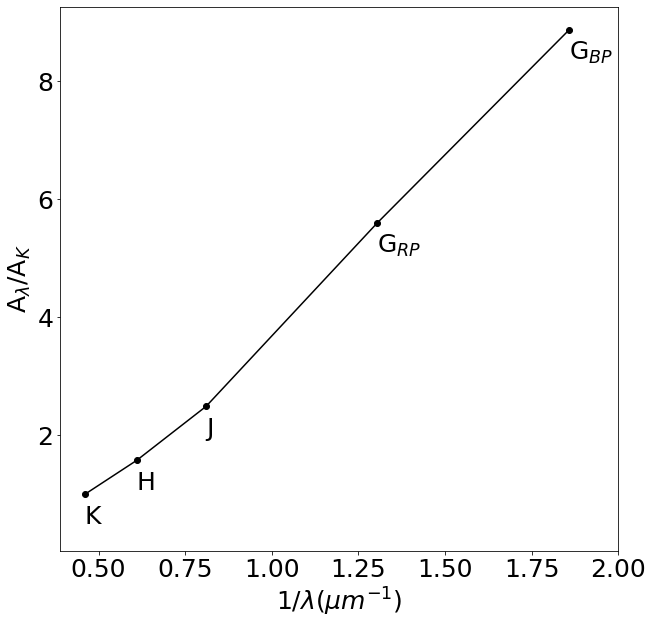

In [6]:
filters_x = np.array([leff['K'],leff['H'],leff['J'],leff['RP'],leff['BP']])
filters = 999999.0*np.ones(len(filters_x))
filters_label = np.array([r'K',r'H',r'J',r'G$_{RP}$',r'G$_{BP}$'])

for i in range(len(filters_x)):
    filters[i] = ccm_alav(filters_x[i],3.1)/ak_av

plt.figure(figsize=[10,10])
plt.scatter(1/filters_x,filters,c='K')
plt.plot(1/filters_x,filters,c='K')
for i in range(len(filters)):
    plt.text((1/filters_x[i]),(filters[i]-0.5),filters_label[i])
    
plt.ylim(0.05,9.25)
plt.xlim(right=2.)

# plt.title(r'A$_\lambda$/A$_K$')
plt.xlabel(r'$1/\lambda (\mu m^{-1}$)')
plt.ylabel(r'A$_\lambda$/A$_K$')
plt.savefig('ccm89.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [7]:
1/ak_av

8.652727840277368

# PARSEC

In [8]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_3_5.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOKASC

In [9]:
# APOKASC
from astropy.io import ascii
kasc = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')

### xmatch DR17
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
_, kasc_ind, dr17_ind = np.intersect1d(kasc['2MASS_ID'],dr17['APOGEE_ID'], return_indices=True)

kascdr17 = dr17[dr17_ind]
kasc = kasc[kasc_ind]

### xmatch kasc2 and kasc3
_, kasc3_ind, kasc_ind = np.intersect1d(kasc3['2MASSID'],kasc['2MASS_ID'], return_indices=True)

kasc = kasc[kasc_ind]
kasc3dr17 = kascdr17[kasc_ind]
kasc3 = kasc3[kasc3_ind]

In [10]:
ageevs = np.where((kasc3['IntAge']>-10.)&(kasc['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kasc3dr17['FE_H']<=0.0)&
                  (kasc3dr17['GAIAEDR3_PARALLAX']/kasc3dr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

kasc3dr17 = kasc3dr17[ageevs]
kasc3 = kasc3[ageevs]

# Gaia

In [11]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

In [12]:
kasc3dr17.columns

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'TELESCOPE'; format = '6A'
    name = 'FIELD'; format = '20A'
    name = 'ALT_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'AK_TARG'; format = 'E'
    name = 'AK_TARG_METHOD'; format = '32A'
    name = 'AK_WISE'; format = 'E'
    name = 'SFD_EBV'; format = 'E'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET4'; format = 'J'
    name = 'TARGFLAGS'; format = '132A'
    name = 'SURVEY'; format = '32A'
    name = 'PROGRAMNAME'; format = '32A'
    name =

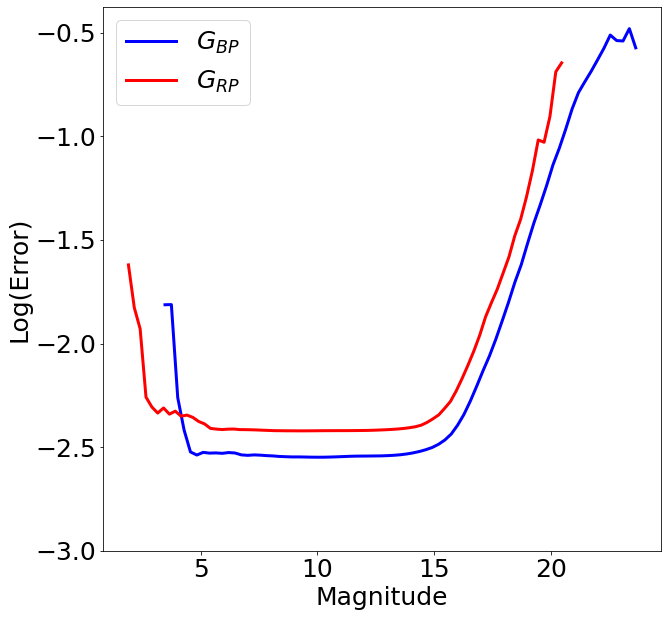

In [13]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight')
plt.show()

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kasc3dr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kasc3dr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

# BaSTI

In [14]:
###tracks
b100solartrack = ascii.read('/Users/joshuapovick/Desktop/Research/BaSTI/z0002y0248m0900solar.track',
                       names=['log(age)','(M/Mo)','log(L/Lo)','logTe','Mv','(U-B)','(B-V)','(V-I)','(V-R)',
                              '(V-J)','(V-K)','(V-L)','(H-K)'])
b100solartrack['log(g)'] = (np.log10(27410)-b100solartrack['log(L/Lo)']+np.log10(b100solartrack['(M/Mo)'])+
                            4*b100solartrack['logTe']-4*np.log10(5778))
b040solartrack = ascii.read('/Users/joshuapovick/Desktop/Research/BaSTI/z0008y0256m0900solar.track',
                       names=['log(age)','(M/Mo)','log(L/Lo)','logTe','Mv','(U-B)','(B-V)','(V-I)','(V-R)',
                              '(V-J)','(V-K)','(V-L)','(H-K)'])
b040solartrack['log(g)'] = (np.log10(27410)-b040solartrack['log(L/Lo)']+np.log10(b040solartrack['(M/Mo)'])+
                            4*b040solartrack['logTe']-4*np.log10(5778))
b100enhantrack = ascii.read('/Users/joshuapovick/Desktop/Research/BaSTI/z0002y0248m0900enhanced.track',
                       names=['log(age)','(M/Mo)','log(L/Lo)','logTe','Mv','(U-B)','(B-V)','(V-I)','(V-R)',
                              '(V-J)','(V-K)','(V-L)','(H-K)'])
b100enhantrack['log(g)'] = (np.log10(27410)-b100enhantrack['log(L/Lo)']+np.log10(b100enhantrack['(M/Mo)'])+
                            4*b100enhantrack['logTe']-4*np.log10(5778))
b040enhantrack = ascii.read('/Users/joshuapovick/Desktop/Research/BaSTI/z0008y0256m0900enhanced.track',
                       names=['log(age)','(M/Mo)','log(L/Lo)','logTe','Mv','(U-B)','(B-V)','(V-I)','(V-R)',
                              '(V-J)','(V-K)','(V-L)','(H-K)'])
b040enhantrack['log(g)'] = (np.log10(27410)-b040enhantrack['log(L/Lo)']+np.log10(b040enhantrack['(M/Mo)'])+
                            4*b040enhantrack['logTe']-4*np.log10(5778))

In [15]:
b_alpha = ascii.read('/Users/joshuapovick/Desktop/Research/BaSTI/BaSTI_alpha_enhancement.txt',
                    names=['ELEMENT','ISOTOPE','SCALED_NUMFRAC','SCALED_MASSFRAC','ENHANCED_NUMFRAC',
                           'ENHANCED_MASSFRAC','ASPLUND'])
b_alpha

ELEMENT,ISOTOPE,SCALED_NUMFRAC,SCALED_MASSFRAC,ENHANCED_NUMFRAC,ENHANCED_MASSFRAC,ASPLUND
str2,int64,float64,float64,float64,float64,float64
C,12,0.245518,0.173285,0.108211,0.076451,8.43
N,14,0.064578,0.053152,0.028462,0.02345,7.83
O,16,0.512966,0.482273,0.714945,0.672836,8.69
NE,20,0.08321,0.098668,0.071502,0.084869,7.93
NA,23,0.001479,0.001999,0.000652,0.000882,6.24
MG,24,0.026308,0.037573,0.029125,0.041639,7.6
AL,27,0.002042,0.003238,0.0009,0.001428,6.45
SI,28,0.024552,0.04052,0.021591,0.035669,7.51
P,30,0.000195,0.000355,8.6e-05,0.000157,5.41


In [16]:
# alpha_idx = np.where((b_alpha['ELEMENT']=='O')|(b_alpha['ELEMENT']=='NE')|(b_alpha['ELEMENT']=='MG')|
#                      (b_alpha['ELEMENT']=='SI')|(b_alpha['ELEMENT']=='S')|(b_alpha['ELEMENT']=='CA'))
alpha_idx = np.where((b_alpha['ELEMENT']=='O')|(b_alpha['ELEMENT']=='MG')|(b_alpha['ELEMENT']=='SI')|
                     (b_alpha['ELEMENT']=='S')|(b_alpha['ELEMENT']=='CA'))
alpha_idx

(array([ 2,  5,  7,  9, 13]),)

In [17]:
asplund = 10**(b_alpha['ASPLUND']-12.0)
b_alpha_enhan = np.sum(np.multiply(b_alpha['ENHANCED_MASSFRAC'][alpha_idx],apslund[alpha_idx]))/np.sum(asplund[alpha_idx])
b_alpha_enhan

# print(np.sum(10**(test_eps+test_abun))/np.sum(10**test_eps))
salfeh_correct = np.log10(0.638*(10**(b_alpha_enhan))+0.362)
print(salfeh_correct)
print('[Fe/H]:-1.00 Corrected to: ',-1.00+salfeh_correct)

NameError: name 'apslund' is not defined

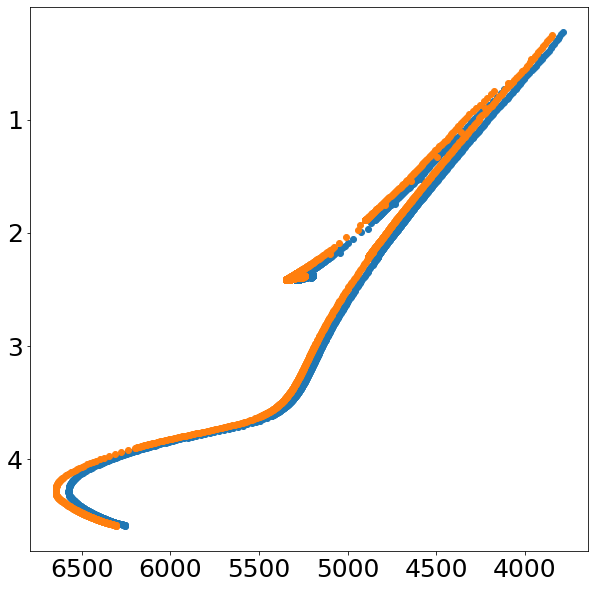

In [18]:
plt.figure(figsize=[10,10])
plt.scatter(10**b100solartrack['logTe'],b100solartrack['log(g)'])
plt.scatter(10**b100enhantrack['logTe'],b100enhantrack['log(g)'])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [19]:
b100enhantrack.columns

<TableColumns names=('log(age)','(M/Mo)','log(L/Lo)','logTe','Mv','(U-B)','(B-V)','(V-I)','(V-R)','(V-J)','(V-K)','(V-L)','(H-K)','log(g)')>

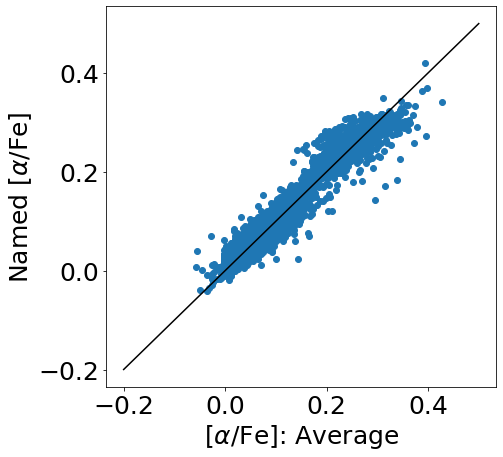

NameError: name 'alsum' is not defined

In [20]:
#O, Mg, Si, S, Ca
alavg = (kasc3dr17['O_FE']+kasc3dr17['MG_FE']+kasc3dr17['SI_FE']+kasc3dr17['S_FE']+kasc3dr17['CA_FE'])/5.
alfeh = kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H']

plt.figure(figsize=[7,7])
plt.scatter(alavg,alfeh)
plt.plot([-0.2,0.5],[-0.2,0.5],c='k')
plt.xlabel(r'[$\alpha$/Fe]: Average')
plt.ylabel(r'Named [$\alpha$/Fe]')
plt.show()

alfin = np.where((np.isfinite(alsum)==True)&(np.isfinite(alfeh)==True))
print(np.poly1d(np.polyfit(alsum[alfin],alfeh[alfin],1)))

plt.plot(alavg-alfeh)
plt.axhline(0.,c='k')
plt.title(r'{:.5f}'.format(np.nanmedian(alavg-alfeh)))
plt.axhline(np.nanmedian(alavg-alfeh),c='r')
plt.ylabel(r'Residual')
plt.show()

In [21]:
b_alpha

ELEMENT,ISOTOPE,SCALED_NUMFRAC,SCALED_MASSFRAC,ENHANCED_NUMFRAC,ENHANCED_MASSFRAC,ASPLUND
str2,int64,float64,float64,float64,float64,float64
C,12,0.245518,0.173285,0.108211,0.076451,8.43
N,14,0.064578,0.053152,0.028462,0.02345,7.83
O,16,0.512966,0.482273,0.714945,0.672836,8.69
NE,20,0.08321,0.098668,0.071502,0.084869,7.93
NA,23,0.001479,0.001999,0.000652,0.000882,6.24
MG,24,0.026308,0.037573,0.029125,0.041639,7.6
AL,27,0.002042,0.003238,0.0009,0.001428,6.45
SI,28,0.024552,0.04052,0.021591,0.035669,7.51
P,30,0.000195,0.000355,8.6e-05,0.000157,5.41


In [22]:
asp = b_alpha['ASPLUND'][alpha_idx]

alasp = 999999.0*np.ones(len(kasc3dr17))
for i in range(len(kasc3dr17)):
    numer = np.sum([asp[0]*kasc3dr17['O_FE'][i],asp[1]*kasc3dr17['MG_FE'][i],
                             asp[2]*kasc3dr17['SI_FE'][i],asp[3]*kasc3dr17['S_FE'][i],
                             asp[4]*kasc3dr17['CA_FE'][i]])
    
    alasp[i] = numer/np.sum(asp)

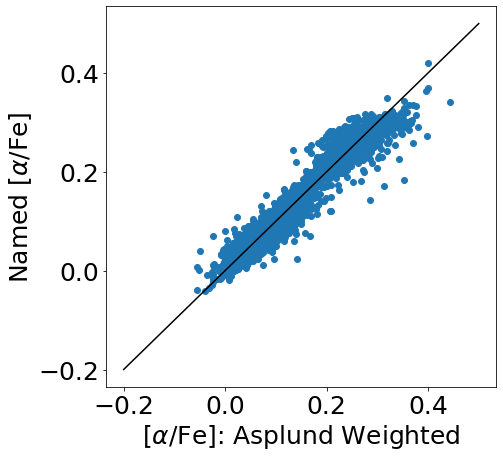

 
0.9438 x + 0.007258


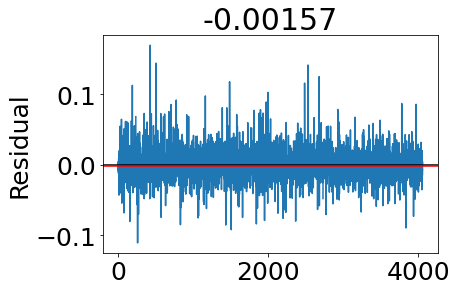

In [23]:
plt.figure(figsize=[7,7])
plt.scatter(alasp,alfeh)
plt.plot([-0.2,0.5],[-0.2,0.5],c='k')
plt.xlabel(r'[$\alpha$/Fe]: Asplund Weighted')
plt.ylabel(r'Named [$\alpha$/Fe]')
plt.show()

alfin = np.where((np.isfinite(alasp)==True)&(np.isfinite(alfeh)==True))
print(np.poly1d(np.polyfit(alasp[alfin],alfeh[alfin],1)))

plt.plot(alasp-alfeh)
plt.axhline(0.,c='k')
plt.title(r'{:.5f}'.format(np.nanmedian(alasp-alfeh)))
plt.axhline(np.nanmedian(alasp-alfeh),c='r')
plt.ylabel(r'Residual')
plt.show()

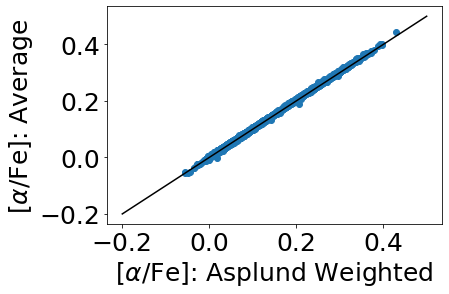

NameError: name 'alsum' is not defined

In [24]:
plt.scatter(alavg,alasp)
plt.plot([-0.2,0.5],[-0.2,0.5],c='k')
plt.xlabel(r'[$\alpha$/Fe]: Asplund Weighted')
plt.ylabel(r'[$\alpha$/Fe]: Average')
plt.show()

alfin2 = np.where((np.isfinite(alsum)==True)&(np.isfinite(testal)==True))
print(np.poly1d(np.polyfit(alsum[alfin2],alfeh[alfin2],1)))

plt.plot(alasp-alavg)
plt.axhline(0.,c='k')
plt.title(r'{:.5f}'.format(np.nanmedian(testal-alsum)))
plt.axhline(np.nanmedian(testal-alsum),c='r')
plt.ylabel(r'Residual')
plt.show()

In [25]:
10**(b_alpha['ENHANCED_MASSFRAC'][alpha_idx]-12.0)
b_alpha['ASPLUND'][alpha_idx]

8.69
7.6
7.51
7.12
6.34


In [26]:
sum(np.multiply(b_alpha['ENHANCED_MASSFRAC'][alpha_idx],
                b_alpha['ASPLUND'][alpha_idx]))/sum(b_alpha['ASPLUND'][alpha_idx])

0.17730240284487386

In [27]:
b_alpha

ELEMENT,ISOTOPE,SCALED_NUMFRAC,SCALED_MASSFRAC,ENHANCED_NUMFRAC,ENHANCED_MASSFRAC,ASPLUND
str2,int64,float64,float64,float64,float64,float64
C,12,0.245518,0.173285,0.108211,0.076451,8.43
N,14,0.064578,0.053152,0.028462,0.02345,7.83
O,16,0.512966,0.482273,0.714945,0.672836,8.69
NE,20,0.08321,0.098668,0.071502,0.084869,7.93
NA,23,0.001479,0.001999,0.000652,0.000882,6.24
MG,24,0.026308,0.037573,0.029125,0.041639,7.6
AL,27,0.002042,0.003238,0.0009,0.001428,6.45
SI,28,0.024552,0.04052,0.021591,0.035669,7.51
P,30,0.000195,0.000355,8.6e-05,0.000157,5.41


In [28]:
np.sum(np.multiply(b_alpha['ASPLUND'],np.log10(np.divide(b_alpha['ENHANCED_NUMFRAC'],b_alpha['SCALED_NUMFRAC'])))[alpha_idx])/np.sum(b_alpha['ASPLUND'][alpha_idx])

0.050978255197619726

In [29]:
np.sum(np.log10(np.divide(b_alpha['ENHANCED_NUMFRAC'],b_alpha['SCALED_NUMFRAC']))[alpha_idx])/5.

0.05016944759072743

In [30]:
-1+np.log10(0.638*10**(0.050978255197619726)+0.362)

-0.9667926214130528

In [31]:
np.log10(0.638*10**(0.050978255197619726)+0.362)

0.03320737858694721

In [32]:
-0.70+np.log10(0.638*10**(0.050978255197619726)+0.362)

-0.6667926214130527

In [33]:
(np.log10(np.sum(b_alpha['ENHANCED_NUMFRAC'][alpha_idx])/
         b_alpha['ENHANCED_NUMFRAC'][np.where(b_alpha['ELEMENT']=='FE')])
- np.log10(np.sum(b_alpha['SCALED_NUMFRAC'][alpha_idx])/
         b_alpha['SCALED_NUMFRAC'][np.where(b_alpha['ELEMENT']=='FE')]))

0.48614888498337305


In [34]:
-1+np.log10(0.638*10**(0.48614888498337305)+0.362)

-0.635223474669592

In [35]:
asplund = ascii.read('/Users/joshuapovick/Desktop/Research/Asplund/Asplund.txt',
                    names=['Z','ELEMENT','PHOTOSPHERE','PHOTOSPHERE_ERR','METEORITES','METEORITES_ERR'])

In [36]:
np.sum(10**(asplund['PHOTOSPHERE'][np.where(asplund['PHOTOSPHERE']!=999999.0)][2:]-12.0))

0.0010412266390016865

In [37]:
np.log10(10**(asplund['PHOTOSPHERE'][np.where(asplund['ELEMENT']=='O')]-12.)/10**(asplund['PHOTOSPHERE'][np.where(asplund['ELEMENT']=='FE')]-12.))



1.1899999999999995


In [38]:
10**(asplund['PHOTOSPHERE'][np.where(asplund['ELEMENT']=='O')]-12.)

0.0004897788193684457


In [39]:
10**(asplund['PHOTOSPHERE'][np.where(asplund['ELEMENT']=='FE')]-12.)

3.1622776601683795e-05


In [40]:
asplund['ELEMENT']

H
HE
LI
BE
B
C
N
O
F
NE
NA


# Jamie Tracks

In [41]:
j031al00 = ascii.read('m090fhm031y273a17al00_grnodf.track')

j020al00 = ascii.read('m090fhm020y273a17al00_grnodf.track')
j040al00 = ascii.read('m090fhm040y273a17al00_grnodf.track')

j046al00 = ascii.read('m090fhm046y273a17al00_grnodf.track')

j060al00 = ascii.read('m090fhm060y273a17al00_grnodf.track')
j060al02 = ascii.read('m090fhm060y273a17al02_grnodf.track')
j060al04 = ascii.read('m090fhm060y273a17al04_grnodf.track')

In [42]:
print(j031al00.columns)
print(' ')
print(j060al04.columns)

<TableColumns names=('col1','col2','col3','col4','col5','col6','col7','col8','col9','col10','col11','col12','col13','col14','col15','col16','col17','col18','col19','col20','col21','col22','col23','col24','col25','col26','col27','col28','col29','col30','col31','col32','col33','col34','col35','col36','col37','col38','col39','col40','col41','col42','col43','col44','col45','col46','col47','col48','col49','col50','col51','col52','col53','col54','col55','col56','col57','col58','col59','col60','col61','col62','col63','col64','col65','col66','col67','col68','col69','col70','col71','col72','col73','col74','col75','col76','col77','col78','col79','col80','col81','col82','col83')>
 
<TableColumns names=('logg','Teff','Age_(Gyr)','C12_surf','C13_surf','N14_surf','X_surf')>


In [43]:
j031al00

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col70,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81,col82,col83
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1154,1.84002885e-05,1.16805788,0.807044597,2.77828403,3.64980028,0.0,0.9,0.0,1107200.0,0.032181,4810200000000.0,26.612,6.04421745,-1.49240269,12.6821669,0.999212151,0.0,0.718415,0.2726534,0.0089021,9.72698007e-05,1.37892047e-36,1.64270851e-64,2.94782384e-38,0.0,0.0,14.7249902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.95000168e-05,0.00151594096,1.70290025e-05,0.000448904984,0.0,0.00416022447,0.0,8.33970219e-06,2.95000168e-05,0.00151594096,1.70290025e-05,0.000448904984,0.0,0.00416022447,0.0,8.33970219e-06,1.49999968e-05,2e-10,2e-09,3e-11,0.718415,0.2726534,0.0089021,0.0123913059,0.0,0.0,6.7805106e+55,6.7805106e+55,0.0,0.0,0.0,0.0,16858459.6,0.0,0.0,0.0,0.0,0.0,0.0,4.34021805,0.9
2,1155,1.99814409e-05,1.15792948,0.801365865,2.7896415,3.65010754,0.0,0.9,0.0,1121200.0,0.033422,5059200000000.0,26.373,6.04969439,-1.47596743,12.7040833,0.999212167,0.0,0.718415,0.2726534,0.0089021,0.000119111084,2.40431379e-36,4.33512977e-64,5.32838534e-38,0.0,0.0,14.3855306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.95000227e-05,0.00151594096,1.70290025e-05,0.000448904984,0.0,0.00416022447,0.0,8.33970219e-06,2.95000227e-05,0.00151594096,1.70290025e-05,0.000448904984,0.0,0.00416022447,0.0,8.33970219e-06,1.49999928e-05,2e-10,2e-09,3e-11,0.718415,0.2726534,0.0089021,0.0123913059,0.0,0.0,6.61139422e+55,6.61139422e+55,0.0,0.0,0.0,0.0,16902296.0,0.0,0.0,0.0,0.0,0.0,0.0,4.3459545,0.9
3,1155,2.10355424e-05,1.15140517,0.797672597,2.79702803,3.6503231,0.0,0.9,0.0,1130500.0,0.034256,5228200000000.0,26.22,6.05325968,-1.46526746,12.7183514,0.999212179,0.0,0.718415,0.2726534,0.0089021,0.000135946065,3.45069197e-36,8.13995351e-64,7.82642777e-38,0.0,0.0,14.1710164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.95000276e-05,0.00151594096,1.70290025e-05,0.000448904984,0.0,0.00416022447,0.0,8.33970219e-06,2.95000276e-05,0.00151594096,1.70290025e-05,0.000448904984,0.0,0.00416022447,0.0,8.33970219e-06,1.49999896e-05,2e-10,2e-09,3e-11,0.718415,0.2726534,0.0089021,0.0123913059,0.0,0.0,6.50357256e+55,6.50357256e+55,0.0,0.0,0.0,0.0,16896012.3,0.0,0.0,0.0,0.0,0.0,0.0,4.34963334,0.9
4,1155,2.17382768e-05,1.14712328,0.795248562,2.8018761,3.65046464,0.0,0.9,0.0,1136600.0,0.034814,5342200000000.0,26.121,6.0556006,-1.45824199,12.7277196,0.999212187,0.0,0.718415,0.2726534,0.0089021,0.000148167903,4.37044383e-36,1.22958677e-63,1.00638736e-37,0.0,0.0,14.0319714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.95000312e-05,0.00151594096,1.70290025e-05,0.000448904984,0.0,0.00416022447,0.0,8.33970219e-06,2.95000312e-05,0.00151594096,1.70290025e-05,0.000448904984,0.0,0.00416022447,0.0,8.33970219e-06,1.49999872e-05,2e-10,2e-09,3e-11,0.718415,0.2726534,0.0089021,0.0123913059,0.0,0.0,6.43373835e+55,6.43373835e+55,0.0,0.0,0.0,0.0,16891827.0,0.0,0.0,0.0,0.0,0.0,0.0,4.35204831,0.9
5,1155,2.22067664e-05,1.14428853,0.793650707,2.8050

In [113]:
print('Salaris [Fe/H] for [Fe/H] = -0.60 alpha = 0.2',np.round(salarisfeh(-0.60,0.2),2))
print('Salaris [Fe/H] for [Fe/H] = -0.60 alpha = 0.4',np.round(salarisfeh(-0.60,0.4),2))

Salaris [Fe/H] for [Fe/H] = -0.60 alpha = 0.2 -0.46
Salaris [Fe/H] for [Fe/H] = -0.60 alpha = 0.4 -0.31


In [ ]:
plt.figure(figsize=[10,10])
plt.scatter(10**j031al00['col7'],j031al00['col6'],label=r'[Fe/H]: -0.31, [$\alpha$/Fe]: 0.0')
plt.scatter(j060al04['Teff'],j060al04['logg'],label=r'[Fe/H]: -0.60, [$\alpha$/Fe]: 0.4')
plt.scatter(j060al00['Teff'],j060al00['logg'],label=r'[Fe/H]: -0.60, [$\alpha$/Fe]: 0.0')
plt.legend(frameon=False)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.suptitle(r'Mass: 0.9 M$_{\odot}$, Y: 0.273, $\alpha$: 0.17, Grey Atmosphere')
plt.title(r'Salaris([Fe/H] = -0.60, [$\alpha$/Fe] = 0.4): {:.2f}'.format(salarisfeh(-0.60,0.4)))
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

In [ ]:
plt.figure(figsize=[10,10])
plt.scatter(10**j046al00['col7'],j046al00['col6'],label=r'[Fe/H]: -0.46, [$\alpha$/Fe]: 0.0')
plt.scatter(j060al02['Teff'],j060al02['logg'],label=r'[Fe/H]: -0.60, [$\alpha$/Fe]: 0.2')
plt.scatter(j060al00['Teff'],j060al00['logg'],label=r'[Fe/H]: -0.60, [$\alpha$/Fe]: 0.0')
plt.legend(frameon=False)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.suptitle(r'Mass: 0.9 M$_{\odot}$, Y: 0.273, $\alpha$: 0.17, Grey Atmosphere')
plt.title(r'Salaris([Fe/H] = -0.60, [$\alpha$/Fe] = 0.2): {:.2f}'.format(salarisfeh(-0.60,0.2)))
plt.xlabel(r'Teff')
plt.ylabel(r'Log(g)')

In [ ]:
np.sum(asplund['PHOTOSPHERE'][2:][np.where(asplund['PHOTOSPHERE'][2:]!=999999.0)]-12.0)

In [ ]:
np.sum(asplund['PHOTOSPHERE'][np.where(asplund['PHOTOSPHERE']!=999999.0)]-12.0)

In [ ]:
1--592.1/-593.1700000000002

In [ ]:
10**asplund['PHOTOSPHERE'][np.where(asplund['ELEMENT']=='O')]-12.0

In [ ]:
10**asplund['PHOTOSPHERE'][np.where(asplund['ELEMENT']=='FE')]-12.0

In [ ]:
np.log10(489778807.36844563/31622764.60168379)

In [ ]:
10**((asplund['PHOTOSPHERE'][np.where(asplund['ELEMENT']=='O')]-12.0)/
 (asplund['PHOTOSPHERE'][np.where(asplund['ELEMENT']=='FE')]-12.0))

In [59]:
cfrac = (10**(8.43))/(10**(8.43)+10**(7.83))
nfrac = (10**(7.83))/(10**(8.43)+10**(7.83))

cnfe = np.log10(cfrac*10**(kasc3dr17['C_FE'])+nfrac*10**(kasc3dr17['N_FE']))

In [ ]:
plt.scatter(kasc3dr17['FE_H'],cnfe)

# Residuals

In [60]:
ages = fits.getdata('APOKASC_rgb_Sal_age_ak.fits')
# agesCN = fits.getdata('APOKASC_rgb_CN_age_ak.fits')
agesCN = fits.getdata('APOKASC_rgb_SalarisCN2.fits')

resids = kasc3['IntAge']-ages['AGE']
residsCN = kasc3['IntAge']-agesCN['AGE']

In [112]:
def salarisfeh(feh,al):
    '''
    Calculate the Salaris corrected from Salaris et al. 1993
    
    Inputs:
    ------
        feh: [Fe/H]
        al: [alpha/Fe]
    
    Output:
    ------
        salfeh: Salaris Corrected [Fe/H]
    '''
    
    salfeh = feh+np.log10(0.638*(10**(al))+0.362)
    return salfeh

salfehs = 999999.0*np.ones(len(kasc3dr17))
for i in tqdm_notebook(range(len(kasc3dr17))):
    salfehs[i] = salarisfeh(kasc3dr17['FE_H'][i],(kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H'])[i])

In [62]:
def salariscorrectedfeh(abund):
    '''
    Inputs:
    ------
        feh: metallcity of a star
        cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])

    Output:
    ------
        salfeh: Salaris corrected metallicity
    '''

    ### Salaris coefficients
    # (atomic_wgts/hydrogen_wgt) = (C,N,O,Mg,Si,S,Ca,Ti)/H
    asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
    mass_ratio = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC
    ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
    XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
    sal_a = np.sum(XZ_k)
    sal_b = 1 - sal_a

    ### Alpha+C+N
    wgts = asplund/np.sum(asplund)

    # Replace bad values with solar
    for i in range(len(abund[:,0])):
        if abund[i,0] < -10. or abund[i,0] > 10. or np.isfinite(abund[i,0])==False:
            abund[i,0] = 0.0
        if abund[i,1] < -10. or abund[i,1] > 10. or np.isfinite(abund[i,1])==False:
            abund[i,1] = 0.0 

    feh = abund[0,0]
    feh_err = abund[0,1]
    cnalpha = abund[1:,0]
    cnalpha_err = abund[1:,1]

    nsamples = 1000
    salfehdist = 999999.0*np.ones(nsamples)

    noisyfeh = np.random.normal(feh,feh_err,nsamples)
    for i in range(nsamples):

        noisycnalpha = 999999.0*np.ones(len(cnalpha))
        for j in range(len(cnalpha)):
            noisycnalpha[j] = np.random.normal(cnalpha[j],cnalpha_err[j])

        cnafe = np.log10(np.sum(np.multiply(10**noisycnalpha,wgts)))
        salfehdist[i] = noisyfeh[i] + np.log10(sal_a*10**(cnafe)+sal_b)

    calc_salfeh = np.nanmedian(salfehdist)
    calc_salfeh_err = mad(salfehdist)

    return calc_salfeh, calc_salfeh_err

In [48]:
# salCNfeh2 = 999999.0*np.ones(len(kasc3dr17))
# for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
#     ab = np.array([[kascdr17['FE_H'][i],kascdr17['C_FE'][i],kascdr17['N_FE'][i],
#                     kascdr17['O_FE'][i],kascdr17['MG_FE'][i],kascdr17['SI_FE'][i],
#                     kascdr17['S_FE'][i],kascdr17['CA_FE'][i],kascdr17['TI_FE'][i]],
#                    [kascdr17['FE_H_ERR'][i],kascdr17['C_FE_ERR'][i],
#                     kascdr17['N_FE_ERR'][i],kascdr17['O_FE_ERR'][i],
#                     kascdr17['MG_FE_ERR'][i],kascdr17['SI_FE_ERR'][i],
#                     kascdr17['S_FE_ERR'][i],kascdr17['CA_FE_ERR'][i],
#                     kascdr17['TI_FE_ERR'][i]]]).T
#     corrfeh, _ = salariscorrectedfeh(ab)
#     salCNfeh[i] = corrfeh

In [49]:
salCNfeh2 = 999999.0*np.ones(len(kasc3dr17))
salCNfeh2_err = 999999.0*np.ones(len(kasc3dr17))
for i in tqdm_notebook(range(len(kasc3dr17))):
    ab = np.array([[kascdr17['FE_H'][i],kascdr17['C_FE'][i],kascdr17['N_FE'][i],
                    kascdr17['O_FE'][i],kascdr17['MG_FE'][i],kascdr17['SI_FE'][i],
                    kascdr17['S_FE'][i],kascdr17['CA_FE'][i],kascdr17['TI_FE'][i]],
                   [kascdr17['FE_H_ERR'][i],kascdr17['C_FE_ERR'][i],
                    kascdr17['N_FE_ERR'][i],kascdr17['O_FE_ERR'][i],
                    kascdr17['MG_FE_ERR'][i],kascdr17['SI_FE_ERR'][i],
                    kascdr17['S_FE_ERR'][i],kascdr17['CA_FE_ERR'][i],
                    kascdr17['TI_FE_ERR'][i]]]).T
    corrfeh, corrfeh_err = salariscorrectedfeh(ab)
    salCNfeh2[i] = corrfeh
    salCNfeh2_err[i] = corrfeh_err

In [50]:
# print('Normal',len(np.squeeze(np.where(salfehs>0.))))
print('Normal+C+N',len(np.squeeze(np.where(salCNfeh2>0.))))

Normal+C+N 1646


In [51]:
max(salCNfeh2)

0.5487344818067269

In [52]:
max(massive['MH'])

0.0

In [53]:
age_arr[0]==age_arr[1]

NameError: name 'age_arr' is not defined

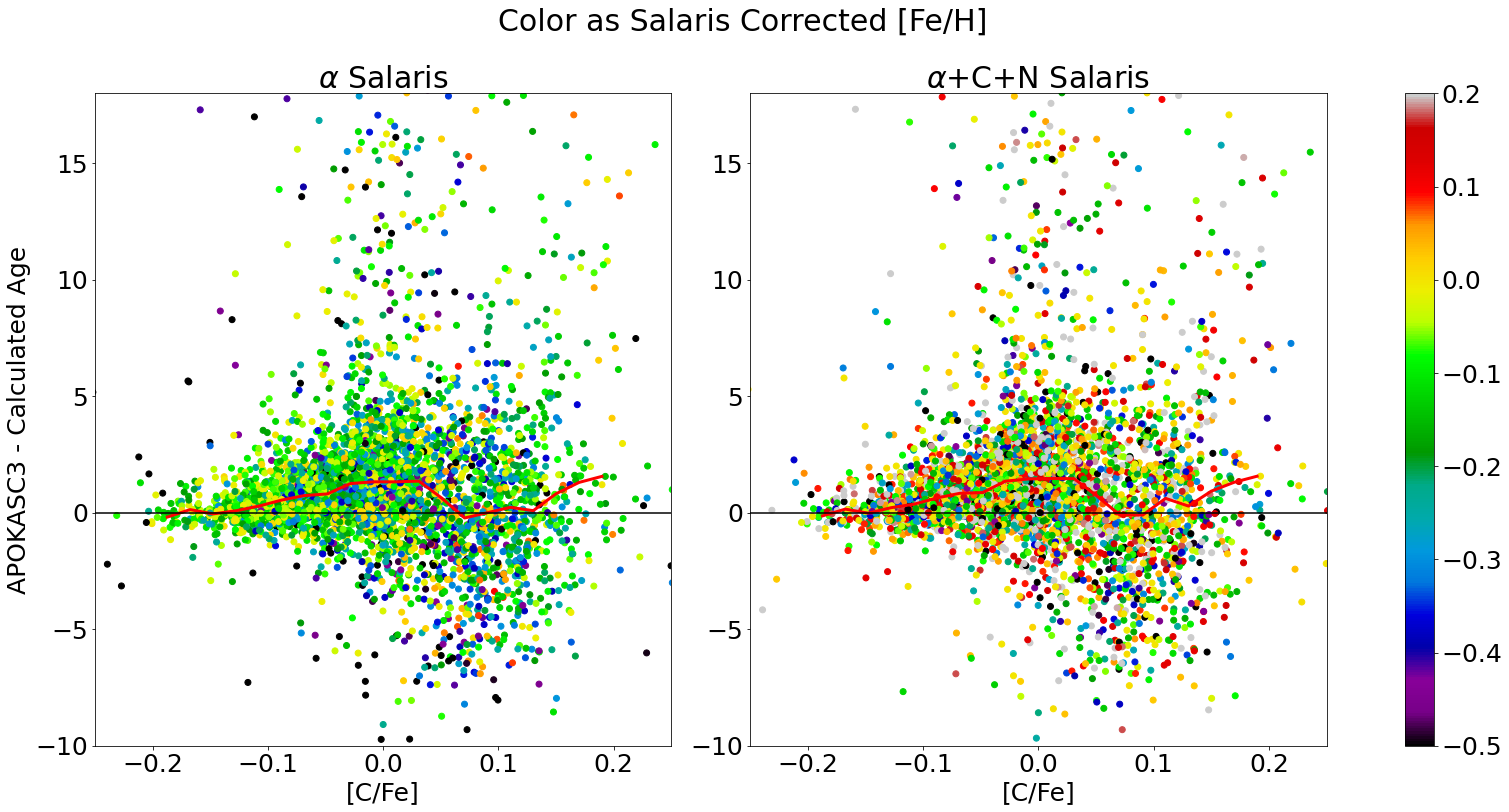

In [54]:
# fig,ax = plt.subplots(1,2,figsize=[24,12])
fig, ax = plt.subplots(ncols=3,figsize=(24,12),gridspec_kw={"width_ratios":[1,1, 0.05]})

r_arr = np.array([resids,residsCN])
age_arr = np.array([ages['AGE'],agesCN['AGE']])
salcols = np.array([salfehs,salCNfeh2])

for i in range(len(ax)-1):
    cln = np.where((kasc3dr17['C_FE']>-10.)&(r_arr[i]>-20.))
    pl = ax[i].scatter(kasc3dr17['C_FE'][cln],r_arr[i][cln],
                       c=salcols[i][cln],cmap='nipy_spectral',vmax=0.2,vmin=-0.5)
    
    nbins = 20
    cln2 = np.where((kasc3dr17['C_FE']>-0.2)&(kasc3dr17['C_FE']<0.2)&(r_arr[i]>-20.))
    cfe_med,cfe_edges,_ = binned_statistic(kasc3dr17['C_FE'][cln2],r_arr[i][cln2],
                                           statistic='median',bins=nbins)
    ax[i].plot((cfe_edges[:-1]+cfe_edges[1:])/2,cfe_med,c='red',lw=3)
    
    ax[i].axhline(0.0,c='k')
    ax[i].set_xlim(-0.25,0.25)
    ax[i].set_ylim(-10,18)
    ax[i].set_xlabel(r'[C/Fe]')

ax[0].set_title(r'$\alpha$ Salaris')
ax[1].set_title(r'$\alpha$+C+N Salaris')

ax[0].set_ylabel(r'APOKASC3 - Calculated Age')

fig.colorbar(pl,cax=ax[-1])

plt.suptitle(r'Color as Salaris Corrected [Fe/H]')
plt.savefig('../plots/cfe_resid_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

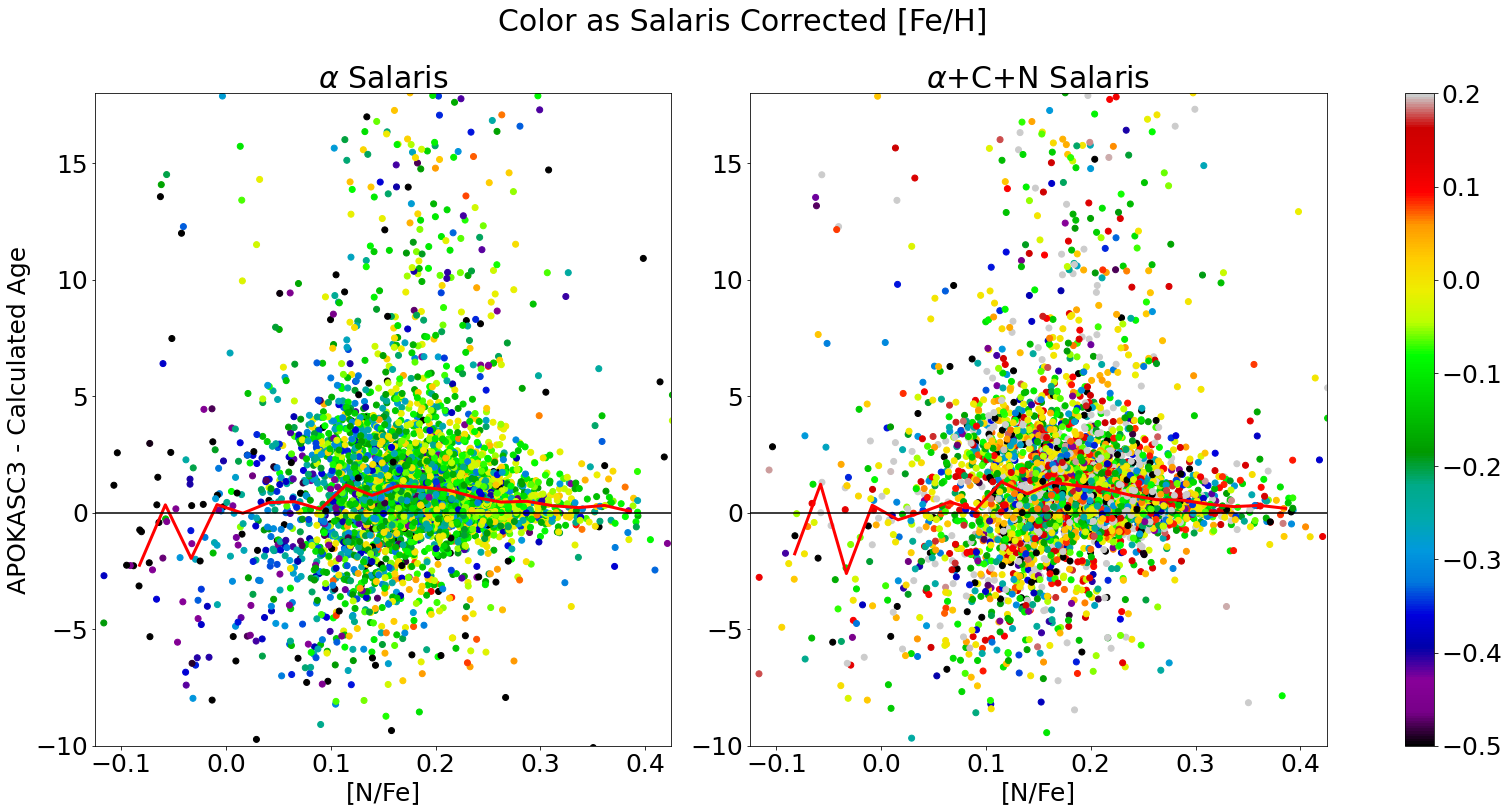

In [55]:
fig, ax = plt.subplots(ncols=3,figsize=(24,12),gridspec_kw={"width_ratios":[1,1, 0.05]})

r_arr = np.array([resids,residsCN])
age_arr = np.array([ages['AGE'],agesCN['AGE']])
salcols = np.array([salfehs,salCNfeh2])

for i in range(len(ax)-1):
    cln = np.where((kasc3dr17['N_FE']>-10.)&(r_arr[i]>-20.))
    pl = ax[i].scatter(kasc3dr17['N_FE'][cln],r_arr[i][cln],
                       c=salcols[i][cln],cmap='nipy_spectral',vmax=0.2,vmin=-0.5)
    
    nbins = 20
    cln2 = np.where((kasc3dr17['N_FE']>-0.1)&(kasc3dr17['N_FE']<0.4)&(r_arr[i]>-20.))
    nfe_med,nfe_edges,_ = binned_statistic(kasc3dr17['N_FE'][cln2],r_arr[i][cln2],
                                           statistic='median',bins=nbins)
    ax[i].plot((nfe_edges[:-1]+nfe_edges[1:])/2,nfe_med,c='red',lw=3)
    
    ax[i].axhline(0.0,c='k')
    ax[i].set_xlim(-0.125,0.425)
    ax[i].set_ylim(-10,18)
    ax[i].set_xlabel(r'[N/Fe]')

ax[0].set_title(r'$\alpha$ Salaris')
ax[1].set_title(r'$\alpha$+C+N Salaris')

ax[0].set_ylabel(r'APOKASC3 - Calculated Age')

fig.colorbar(pl,cax=ax[-1])

plt.suptitle(r'Color as Salaris Corrected [Fe/H]')
plt.savefig('../plots/nfe_resid_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [56]:
len(cnfe)

NameError: name 'cnfe' is not defined

In [ ]:
salcols[0]==salcols[1]

In [ ]:
fig, ax = plt.subplots(ncols=3,figsize=(24,12),gridspec_kw={"width_ratios":[1,1, 0.05]})

r_arr = np.array([resids,residsCN])
age_arr = np.array([ages['AGE'],agesCN['AGE']])
salcols = np.array([salfehs,salCNfeh2])

for i in range(len(ax)-1):
    cln = np.where((cnfe>-10.)&(r_arr[i]>-20.))
    pl = ax[i].scatter(cnfe[cln],r_arr[i][cln],
                       c=salcols[i][cln],cmap='nipy_spectral',vmax=0.5,vmin=-0.5)
    
    nbins = 20
    cln2 = np.where((cnfe>-0.1)&(cnfe<0.2)&(r_arr[i]>-20.))
    nfe_med,nfe_edges,_ = binned_statistic(cnfe[cln2],r_arr[i][cln2],
                                           statistic='median',bins=nbins)
    ax[i].plot((nfe_edges[:-1]+nfe_edges[1:])/2,nfe_med,c='red',lw=3)
    
    ax[i].axhline(0.0,c='k')
    ax[i].set_xlim(-0.1,0.225)
    ax[i].set_ylim(-10,18)
    ax[i].set_xlabel(r'[(C+N)/Fe]')

ax[0].set_title(r'$\alpha$ Salaris')
ax[1].set_title(r'$\alpha$+C+N Salaris')

ax[0].set_ylabel(r'APOKASC3 - Calculated Age')

fig.colorbar(pl,cax=ax[-1])

plt.suptitle(r'Color as Salaris Corrected [Fe/H]')
plt.savefig('../plots/cnfe_resid_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [86]:
def upturn10Gyr(age):
    '''
    Boundary for 10 Gyr upturn in Aetas and APOKASC plot 
    
    Input:
    -----
        age: age in Gyr
        
    Output:
    ------
        ups: value on boundary 
    '''
    ups = np.ones(np.size(age))
    for i in range(np.size(age)):
        if age[i] <= 11:
            up = 11

        else:
            up = age[i]
            
        ups[i] = up

    return ups

def oldapokasc(age):
    '''
    Boundary for old stars in APOKASC given young age by Aetas
    
    Input:
    -----
        age: age in Gyr
    
    Output:
    ------
        olds: value on boundary
    '''
    olds = np.ones(np.size(age))
    for i in range(np.size(age)):
        olds[i] = age[i] - 4
        
    return olds

# upturnstars = np.where(y-upturn10Gyr(x)>0)
# oldapokascstars = np.where(y-oldapokasc(x)<0)
# goodstars = np.where((y-upturn10Gyr(x)<0)&(y-oldapokasc(x)>0))

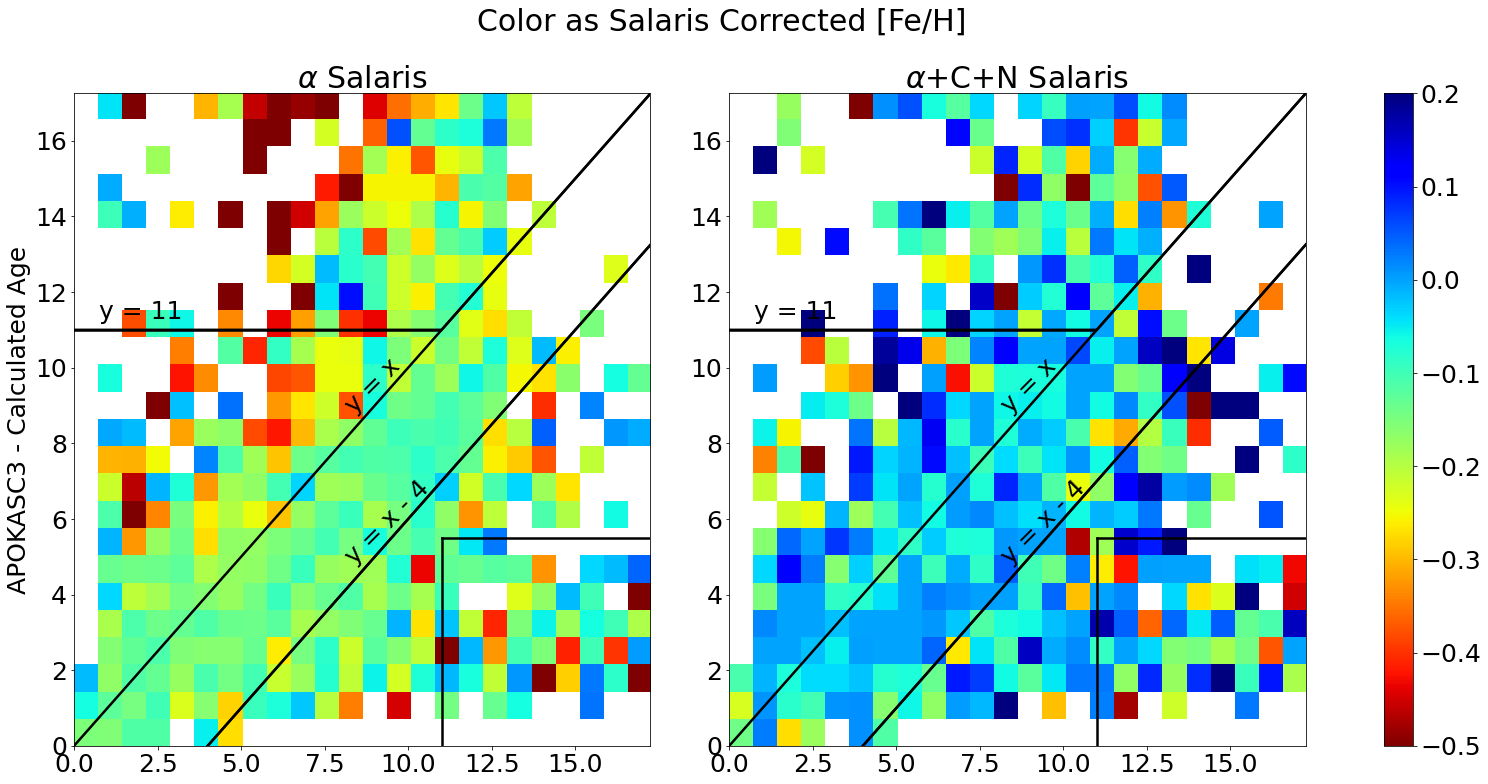

In [87]:
from scipy.stats import binned_statistic_2d

fig, ax = plt.subplots(ncols=3,figsize=(24,12),gridspec_kw={"width_ratios":[1,1,0.05]})

r_arr = np.array([resids,residsCN])
age_arr = np.array([ages['AGE'],agesCN['AGE']])
salcols = np.array([salfehs,salCNfeh2])

xmax = 18
ymax = 18

for i in range(len(ax)-1):
    
#     badcut = np.where()
    ret = binned_statistic_2d(kasc3['IntAge'],age_arr[i],salcols[i],'median',
                              bins=[np.arange(0,xmax,xmax/25),np.arange(0,ymax,ymax/25)])
    
    im = ax[i].imshow(ret.statistic.T, origin='lower',
                      extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                      aspect='auto',interpolation='nearest',cmap='jet_r',vmax=0.2,vmin=-0.5)
    
    ax[i].plot(np.arange(0,18,0.25),upturn10Gyr(np.arange(0,18,0.25)),c='k',lw=2.5)
    ax[i].plot(np.arange(0,18,0.25),oldapokasc(np.arange(0,18,0.25)),c='k',lw=2.5)

    ax[i].plot([11,11],[0,5.5],c='k',lw=2.5)
    ax[i].plot([11,18],[5.5,5.5],c='k',lw=2.5)

    ax[i].text(8,8.8,'y = x',rotation=45)
    ax[i].text(8,4.8,'y = x - 4',rotation=45)
    ax[i].text(0.75,11.3,'y = 11')

    ax[i].plot([0,18],[0,18],lw=2.5,c='k')
    ax[i].plot([4,17.25],[0,13.25],lw=2.5,c='k')
    ax[i].plot([0,10.95],[11,11],lw=2.5,c='k')

    ax[i].set_xlim(0,17.25)
    ax[i].set_ylim(0,17.25)

    plt.xticks(np.arange(18)[::2],np.arange(18)[::2].astype(str))

ax[0].set_title(r'$\alpha$ Salaris')
ax[1].set_title(r'$\alpha$+C+N Salaris')

ax[0].set_ylabel(r'APOKASC3 - Calculated Age')

fig.colorbar(im,cax=ax[-1])

plt.suptitle(r'Color as Salaris Corrected [Fe/H]')
# plt.savefig('../plots/age_age_salaris.pdf',dpi=300,bbox_inches='tight')
plt.show()

0.041623652
0.13338497281074524


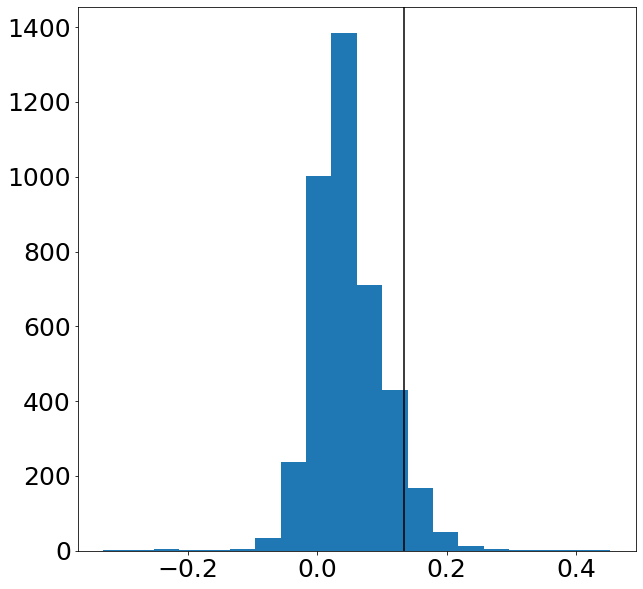

In [88]:
plt.figure(figsize=[10,10])
plt.hist(cnfe,bins=20)
plt.axvline(np.nanmedian(cnfe)+3.0*mad(cnfe),c='k')
print(np.nanmedian(cnfe))
print(np.nanmedian(cnfe)+3.0*mad(cnfe))

In [89]:
highCN = np.where(cnfe>np.nanmedian(cnfe)+3.0*mad(cnfe))
len(np.squeeze(highCN))

296

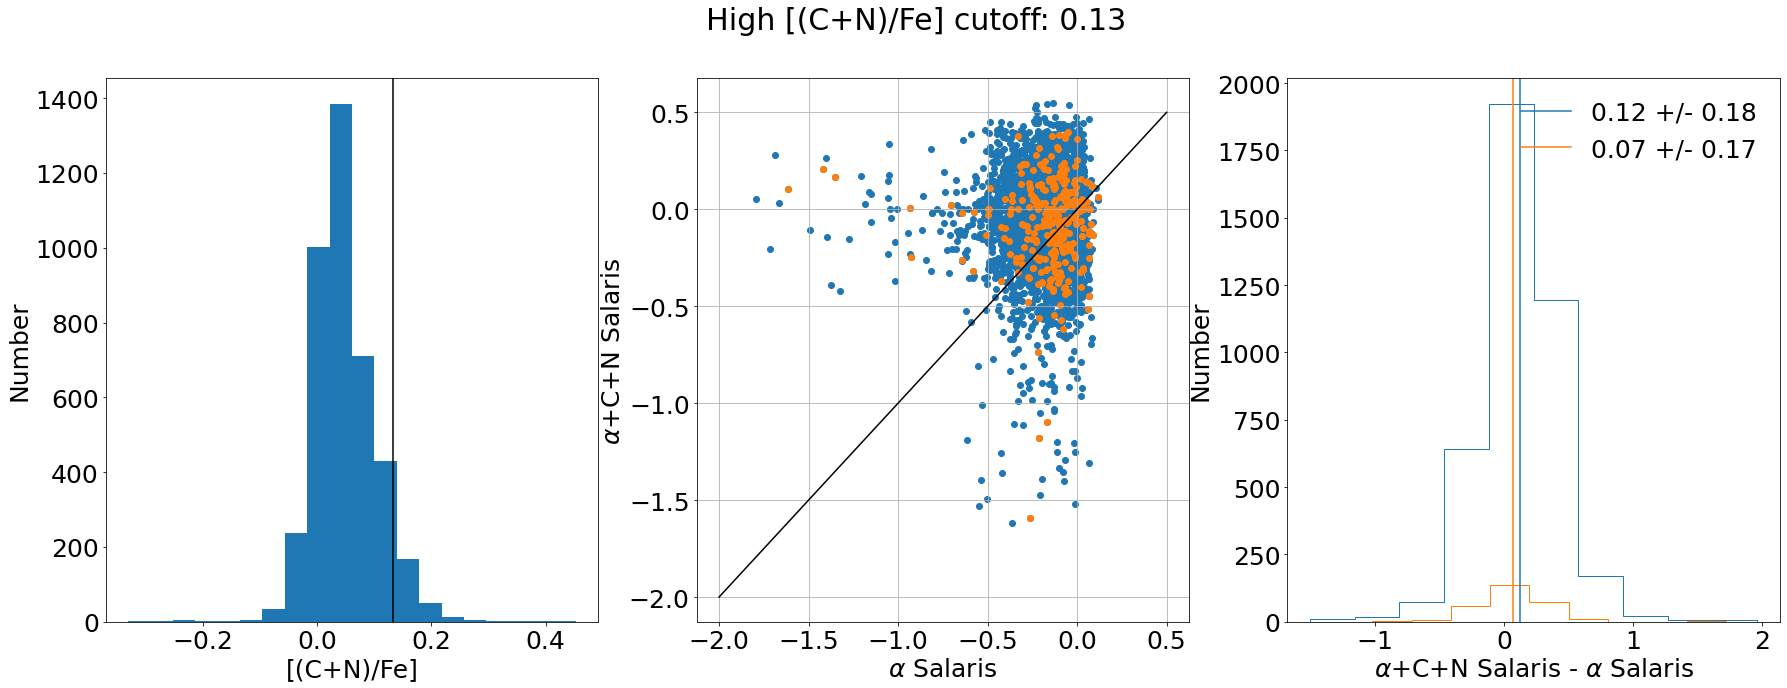

In [90]:
plt.figure(figsize=[30,10])

plt.suptitle(r'High [(C+N)/Fe] cutoff: {:.2f}'.format(np.nanmedian(cnfe)+3.0*mad(cnfe)))

plt.subplot(131)
plt.hist(cnfe,bins=20)
plt.axvline(np.nanmedian(cnfe)+3.0*mad(cnfe),c='k')
plt.ylabel(r'Number')
plt.xlabel(r'[(C+N)/Fe]')

plt.subplot(132)
plt.scatter(salcols[0],salcols[1],)
plt.scatter(salcols[0][highCN],salcols[1][highCN])
plt.plot([-2,0.5],[-2,0.5],c='k')
plt.xlabel(r'$\alpha$ Salaris')
plt.ylabel(r'$\alpha$+C+N Salaris')
plt.grid()

plt.subplot(133)
plt.hist(salcols[1]-salcols[0],color='tab:blue',histtype='step')
plt.axvline(np.nanmedian(salcols[1]-salcols[0]),
            c='tab:blue',label='{:.2f} +/- {:.2f}'.format(np.nanmedian(salcols[1]-salcols[0]),mad(salcols[1]-salcols[0])))
plt.hist(salcols[1][highCN]-salcols[0][highCN],color='tab:orange',histtype='step')
plt.axvline(np.nanmedian(salcols[1][highCN]-salcols[0][highCN]),
            c='tab:orange',label='{:.2f} +/- {:.2f}'.format(np.nanmedian(salcols[1][highCN]-salcols[0][highCN]),mad(salcols[1][highCN]-salcols[0][highCN])))
plt.xlabel(r'$\alpha$+C+N Salaris - $\alpha$ Salaris')
plt.ylabel(r'Number')
plt.legend(frameon=False)

plt.savefig('../plots/highCNSalaris2.pdf',bbox_inches='tight',dpi=300)
plt.show()

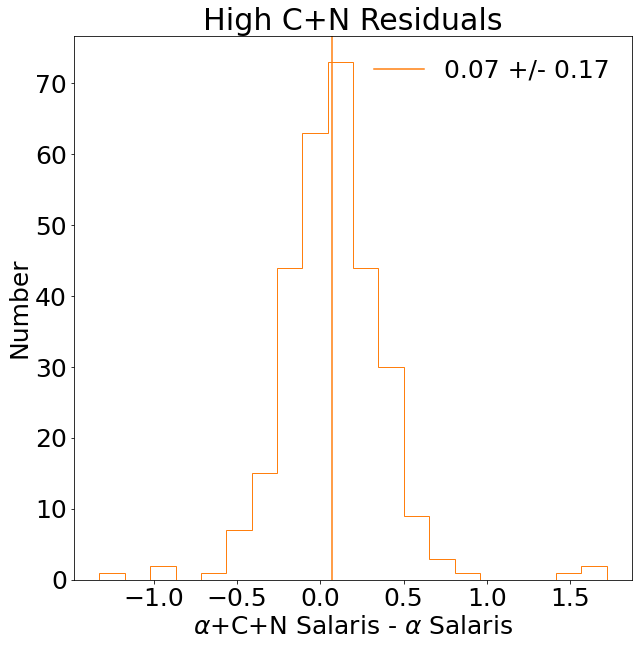

In [91]:
plt.figure(figsize=[10,10])
plt.hist(salcols[1][highCN]-salcols[0][highCN],color='tab:orange',histtype='step',bins=20)
plt.axvline(np.nanmedian(salcols[1][highCN]-salcols[0][highCN]),
            c='tab:orange',label='{:.2f} +/- {:.2f}'.format(np.nanmedian(salcols[1][highCN]-salcols[0][highCN]),
                                                            mad(salcols[1][highCN]-salcols[0][highCN])))
plt.title(r'High C+N Residuals')
plt.xlabel(r'$\alpha$+C+N Salaris - $\alpha$ Salaris')
plt.ylabel(r'Number')
plt.legend(frameon=False)
plt.savefig('../plots/highCNSalarisResid2.pdf',bbox_inches='tight',dpi=300)
plt.show()

In [92]:
# def salariscorrectedfeh(abund):
#     '''
#     Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
#     Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.

#     # hydrogen_wgt = 1.008 #IUPAC
#     # atomic_wgts = np.array([15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
#     # asplund = np.array([8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
#     # ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
#     # a = sum(10**(asplund-12.00)*(atomic_wgts/hydrowh_wgt)*(1/0.0181)) # a = 0.78963627131196057
#     # b = 1-a # b = 0.21036372868803943

#     Inputs:
#     ------
#         feh: metallcity of a star
#         _alpha: array of abundances np.array([O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])

#     Output:
#     ------
#         salfeh: Salaris corrected metallicity
#     '''

#     # Set things up
#     nsamples = 1000
#     asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
#     feh = abund[0,0]
#     feh_err = abund[0,1]
#     _alpha = abund[1:,0]
#     _alpha_err = abund[1:,1]

#     salfehdist = 999999.0*np.ones(nsamples)

#     for i in range(nsamples):

#         # Assign solar value to stars if abundance is bad
#         for j in range(len(_alpha)):
#             if _alpha[j] < -100. or _alpha[j] > 10. or np.isfinite(_alpha[j])==False:
#                 _alpha[j] = 0.0
#             if _alpha_err[j] < -100. or _alpha_err[j] > 10. or np.isfinite(_alpha_err[j])==False:
#                 _alpha_err[j] = 0.0

#         if np.isfinite(feh) == False:
#             feh = 0.0
#             feh_err = 0.0

#         # Create distribution for the different abundances
#         feh_new = np.random.normal(feh,feh_err)
#         _alpha_new = 999999.0*np.ones(len(_alpha))
#         for k in range(len(_alpha)):
#             _alpha_new[k] = np.random.normal(_alpha[k],_alpha_err[k])

#         # Calculate enhancement factor and corrected metallicity
#         fac_acn = sum(10**(asplund+_alpha_new))/sum(10**asplund)
#         salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)

#         salfehdist[i] = salfeh

#     # Calculate the value and error from the distribution
#     calc_salfeh = np.nanmedian(salfehdist)
#     calc_salfeh_err = mad(salfehdist)

#     return calc_salfeh, calc_salfeh_err

In [93]:
kasc3dr17.columns

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'TELESCOPE'; format = '6A'
    name = 'FIELD'; format = '20A'
    name = 'ALT_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'AK_TARG'; format = 'E'
    name = 'AK_TARG_METHOD'; format = '32A'
    name = 'AK_WISE'; format = 'E'
    name = 'SFD_EBV'; format = 'E'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET4'; format = 'J'
    name = 'TARGFLAGS'; format = '132A'
    name = 'SURVEY'; format = '32A'
    name = 'PROGRAMNAME'; format = '32A'
    name =

In [94]:
def alphaCN(abund):
    '''
    Calculate the [($\alpha$+C+N)/Fe] for a star
    
    Input:
    -----
        abund: array of abundances np.array([[C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe]])
    
    Output:
    ------
        cnafe: [($\alpha$+C+N)/Fe]
    '''
    ### log(e_x) from Asplund et al. Solar Composition
    asp = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
    wgts = asp/np.sum(asp)
    
    for i in range(len(abund)):
        if abund[i] < -10. or abund[i] > 10.:
            abund[i] = 0.0
    
    cnafe = np.log10(np.sum(np.multiply(10**abund,wgts)))
    return cnafe

def sal(feh,alpha):
    ''' 
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
    
    Inputs:
    ------
        feh: metallicity of star
        alpha: alph enhancement
    
    Output:
    ------
        sfeh: salaris corrected [Fe/H]
    '''
    ### (atomic_wgts/hydrogen_wgt) = (C,N,O,Mg,Si,S,Ca,Ti)/H
    asp = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
    mass_ratio = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC
    ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
    XZ_k = np.multiply(10**(asp-12.0),mass_ratio/ZX_sol)
    sal_a = np.sum(XZ_k)
    sal_b = 1 - sal_a
    
    sfeh = feh + np.log10(sal_a*10**(alpha)+sal_b)
    
    return sfeh

In [95]:
import numpy as np
asp = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
mass_ratio = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867])/1.008 #IUPAC
ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
XZ_k = np.multiply(10**(asp-12.0),mass_ratio/ZX_sol)
sal_a = np.sum(XZ_k)
sal_b = 1 - sal_a

print('a: ',np.round(sal_a,4))
print('b: ',np.round(sal_b,4))

a:  0.7896
b:  0.2104


In [96]:
max(kasc3dr17['C_FE'])

0.42856005

In [97]:
new_alpha = 999999.0*np.ones(len(kasc3dr17))
for i in tqdm_notebook(range(len(kasc3dr17))):
    new_alpha[i] = alphaCN(np.array([kasc3dr17['C_FE'][i],kasc3dr17['N_FE'][i],kasc3dr17['O_FE'][i],
                                     kasc3dr17['MG_FE'][i],kasc3dr17['SI_FE'][i],kasc3dr17['S_FE'][i],
                                     kasc3dr17['CA_FE'][i],kasc3dr17['TI_FE'][i]]))

In [98]:
new_alpha

array([0.19846239, 0.17748345, 0.20729669, ..., 0.08552768, 0.07616614,
       0.04719775])

In [99]:
salcorfehCN = 999999.0*np.ones(len(kasc3dr17))
for i in tqdm_notebook(range(len(kasc3dr17))):
    salcorfehCN[i] = sal(kasc3dr17['FE_H'][i],new_alpha[i])

In [100]:
max(salcorfehCN)

0.18151465198756733

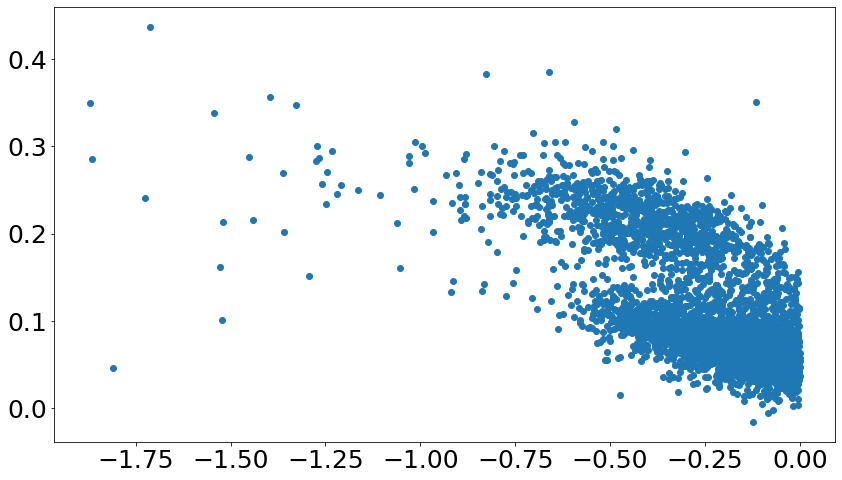

In [101]:
plt.figure(figsize=[14,8])
plt.scatter(kasc3dr17['FE_H'],new_alpha)

(array([2.000e+00, 6.000e+00, 8.000e+00, 2.720e+02, 2.386e+03, 1.141e+03,
        2.170e+02, 1.800e+01, 5.000e+00, 3.000e+00]),
 array([-0.33122355, -0.2527932 , -0.17436284, -0.09593249, -0.01750214,
         0.06092821,  0.13935857,  0.21778892,  0.29621926,  0.3746496 ,
         0.45307997], dtype=float32),
 <a list of 10 Patch objects>)

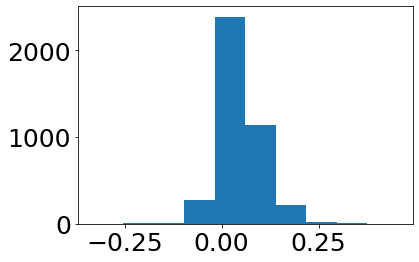

In [102]:
plt.hist(cnfe)

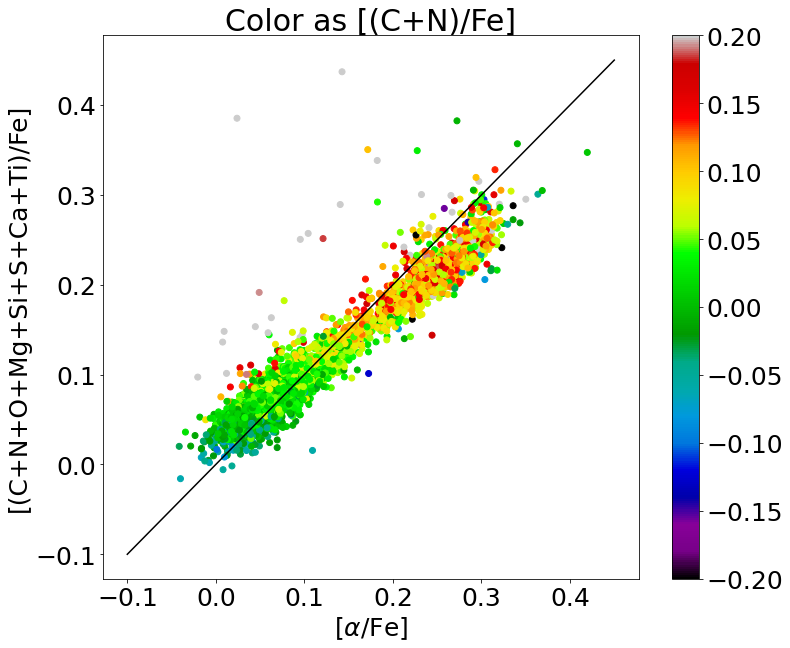

In [103]:
plt.figure(figsize=[12,10])
plt.scatter(kasc3dr17['ALPHA_M']+kasc3dr17['M_H']-kasc3dr17['FE_H'],new_alpha,
            c=cnfe,cmap='nipy_spectral',vmin=-0.2,vmax=0.2)
plt.colorbar()
plt.plot([-0.1,0.45],[-0.1,0.45],c='k')

plt.title(r'Color as [(C+N)/Fe]')
plt.xlabel(r'[$\alpha$/Fe]')
plt.ylabel(r'[(C+N+O+Mg+Si+S+Ca+Ti)/Fe]')
plt.savefig('alpha_newalpha_cnfe.pdf',bbox_inches='tight',dpi=300)
plt.show()

(array([2.000e+00, 3.000e+00, 1.800e+01, 1.821e+03, 1.837e+03, 3.070e+02,
        9.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.5340769 , -0.3863429 , -0.23860891, -0.0908749 ,  0.05685911,
         0.20459312,  0.35232714,  0.50006115,  0.64779514,  0.7955292 ,
         0.9432632 ], dtype=float32),
 <a list of 10 Patch objects>)

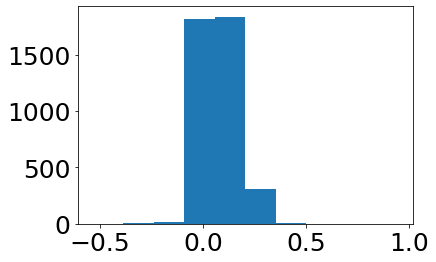

In [104]:
plt.hist(kasc3dr17['TI_FE'])

In [105]:
cnfe

array([ 0.12734185,  0.09769937,  0.13687076, ...,  0.02738123,
        0.01854705, -0.00978689], dtype=float32)

In [106]:
np.sum(10**(asplund['PHOTOSPHERE'][1:]-12.0))

inf

In [107]:
1.00-0.99998

2.0000000000020002e-05

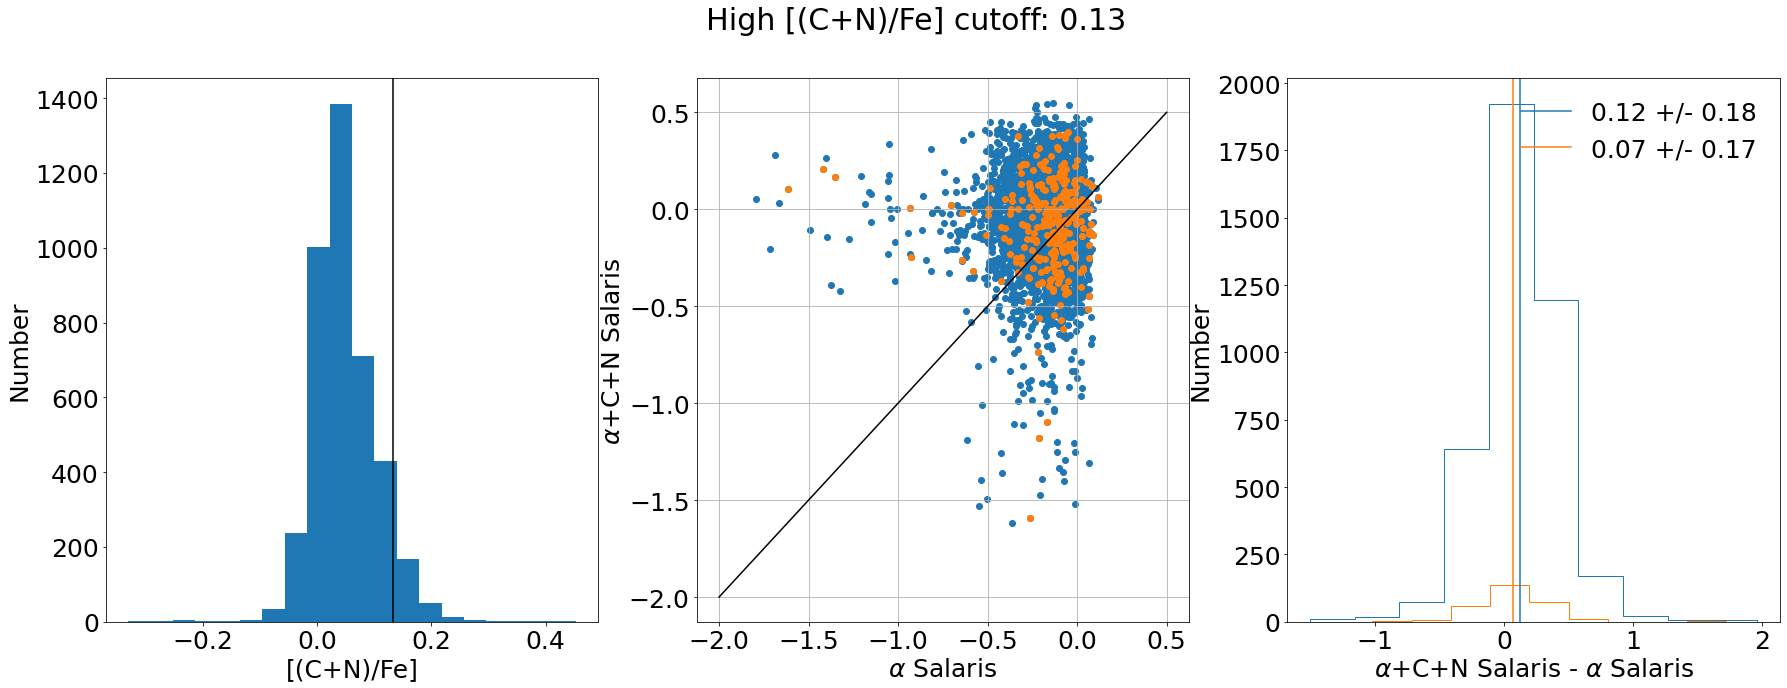

In [109]:
plt.figure(figsize=[30,10])

plt.suptitle(r'High [(C+N)/Fe] cutoff: {:.2f}'.format(np.nanmedian(cnfe)+3.0*mad(cnfe)))

plt.subplot(131)
plt.hist(cnfe,bins=20)
plt.axvline(np.nanmedian(cnfe)+3.0*mad(cnfe),c='k')
plt.ylabel(r'Number')
plt.xlabel(r'[(C+N)/Fe]')

plt.subplot(132)
plt.scatter(salcols[0],salcols[1],)
plt.scatter(salcols[0][highCN],salcols[1][highCN])
plt.plot([-2,0.5],[-2,0.5],c='k')
plt.xlabel(r'$\alpha$ Salaris')
plt.ylabel(r'$\alpha$+C+N Salaris')
plt.grid()

plt.subplot(133)
plt.hist(salcols[1]-salcols[0],color='tab:blue',histtype='step')
plt.axvline(np.nanmedian(salcols[1]-salcols[0]),
            c='tab:blue',label='{:.2f} +/- {:.2f}'.format(np.nanmedian(salcols[1]-salcols[0]),mad(salcols[1]-salcols[0])))
plt.hist(salcols[1][highCN]-salcols[0][highCN],color='tab:orange',histtype='step')
plt.axvline(np.nanmedian(salcols[1][highCN]-salcols[0][highCN]),
            c='tab:orange',label='{:.2f} +/- {:.2f}'.format(np.nanmedian(salcols[1][highCN]-salcols[0][highCN]),mad(salcols[1][highCN]-salcols[0][highCN])))
plt.xlabel(r'$\alpha$+C+N Salaris - $\alpha$ Salaris')
plt.ylabel(r'Number')
plt.legend(frameon=False)

# plt.savefig('../plots/highCNSalaris.pdf',bbox_inches='tight',dpi=300)
plt.show()

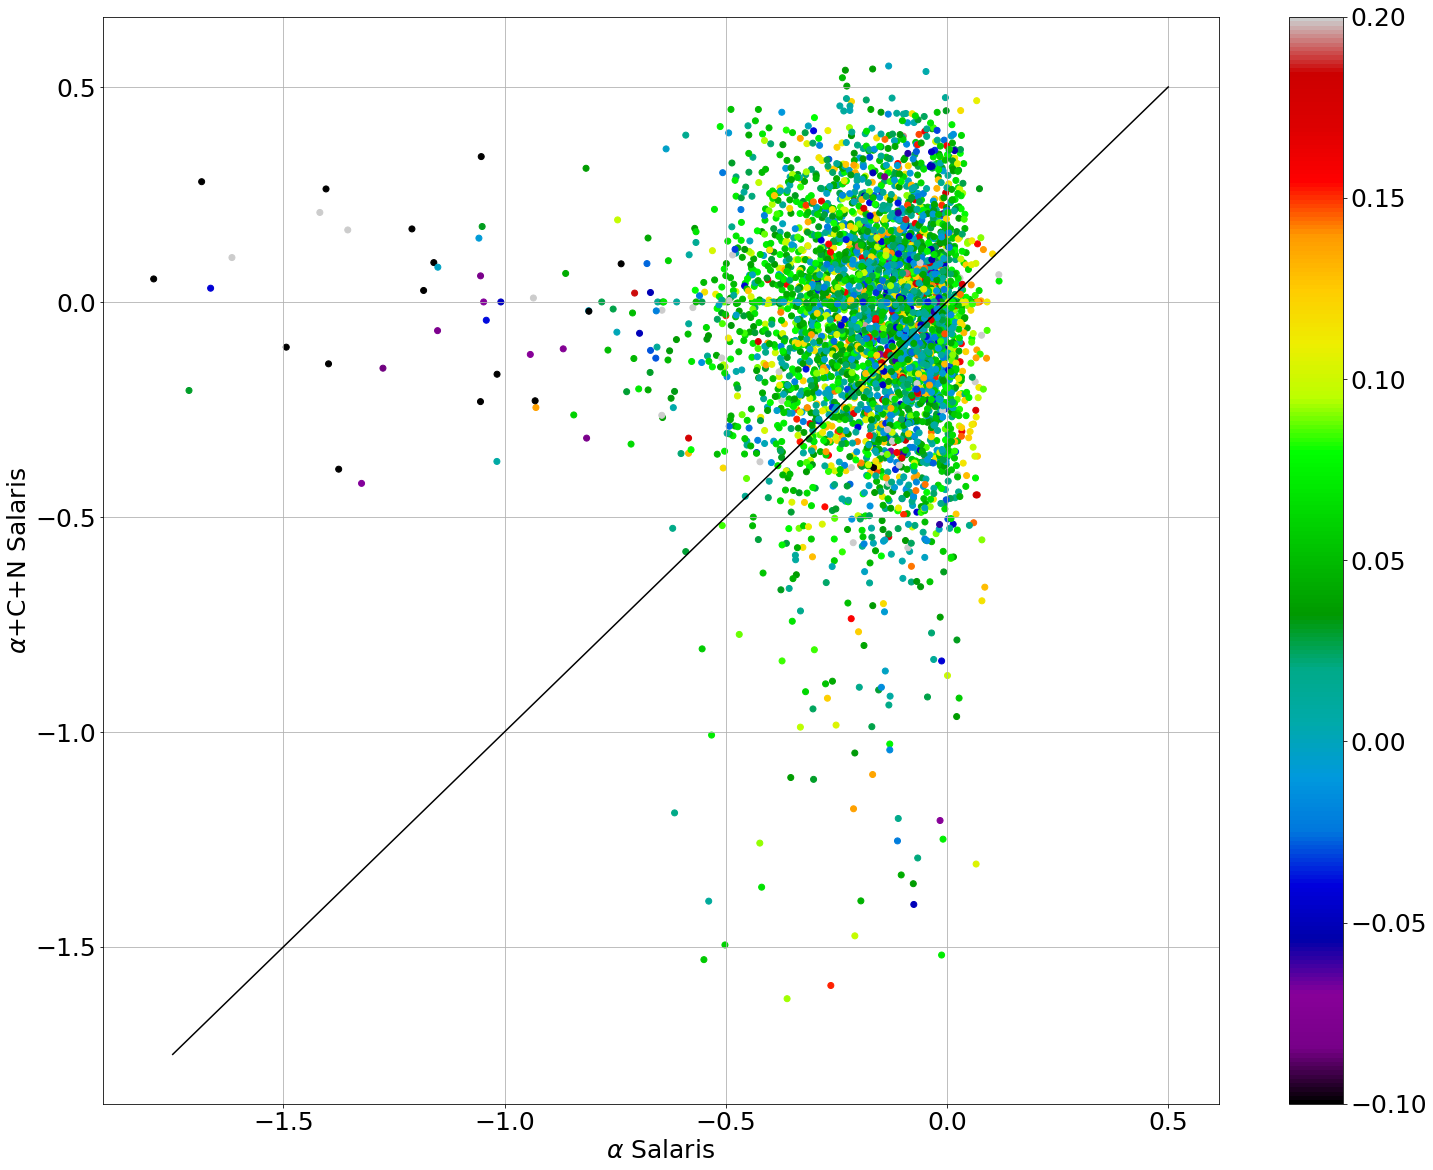

In [110]:
salcols = np.array([salfehs,salCNfeh2])
plt.figure(figsize=[25,20])

plt.scatter(salcols[0],salcols[1],c=cnfe,cmap='nipy_spectral',vmax=0.2,vmin=-0.1)
plt.colorbar()
plt.plot([-1.75,0.5],[-1.75,0.5],c='k')
plt.xlabel(r'$\alpha$ Salaris')
plt.ylabel(r'$\alpha$+C+N Salaris')
plt.grid()
plt.savefig('sal_sal_cnfe_scatter.pdf',dpi=300,bbox_inches='tight')
plt.show()

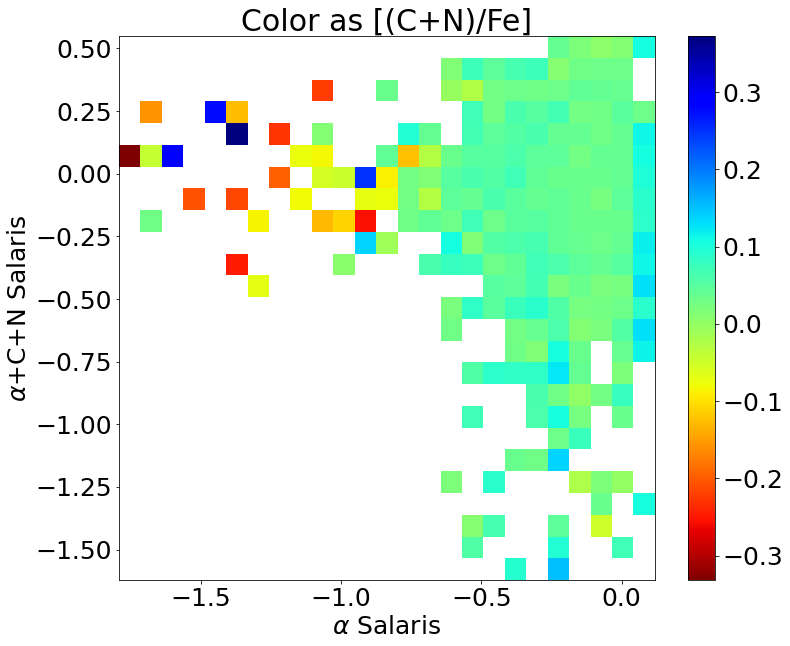

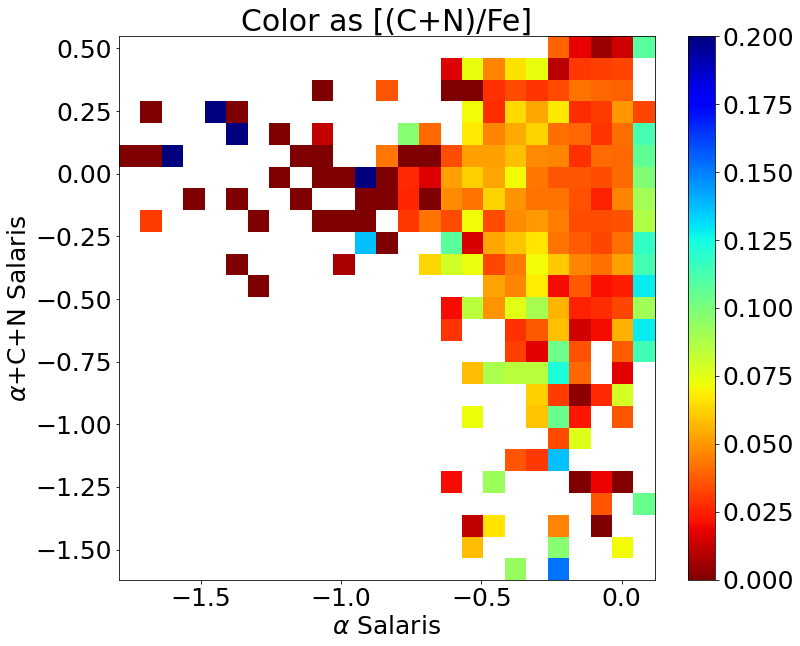

In [111]:
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(salcols[0],salcols[1],cnfe,'median',bins=25)

im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='jet_r')#,vmax=0.2,vmin=-0.5)
plt.colorbar()

plt.title(r'Color as [(C+N)/Fe]')
plt.xlabel(r'$\alpha$ Salaris')
plt.ylabel(r'$\alpha$+C+N Salaris')
plt.show()

plt.figure(figsize=[12,10])
ret = binned_statistic_2d(salcols[0],salcols[1],cnfe,'median',bins=25)

im = plt.imshow(ret.statistic.T, origin='lower',
                extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='jet_r',vmax=0.2,vmin=0.0)#,vmax=0.2,vmin=-0.5)
plt.colorbar()

plt.title(r'Color as [(C+N)/Fe]')
plt.xlabel(r'$\alpha$ Salaris')
plt.ylabel(r'$\alpha$+C+N Salaris')
plt.savefig('sal_sal_cnfe.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
len(np.squeeze(np.where(cnfe<0.)))/len(cnfe)